In [2]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append(os.getcwd())
from STdGCN.STdGCN import run_STdGCN
import scanpy as sc
import anndata as ad

In [21]:
prefix = "MERFISH_ID1"
res = 200
idx1=0.01

"{0}_{1}_ground_truth_{2}.tsv".format(prefix,res,idx1)

'MERFISH_ID1_200_ground_truth_0.01.tsv'

In [2]:
idx1 = 1
idx2 = 0.01
res = 50

file_name = "MERFISH_ID{0}_{1}".format(idx1,idx2)
out_prefix = "MERFISH_ID{0}_{1}".format(idx1,idx2)
pseudo_spot_simulation_paras = {
    'spot_num': 30000,
    'min_cell_num_in_spot': 8,
    'max_cell_num_in_spot': 12,
    'generation_method': 'celltype',
    'max_cell_types_in_spot': 4,   
}

paths = {
    'sc_path': '/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/MERFISH/sc_data',
    'ST_path': '/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/MERFISH/ST_data',
    'output_path': '/data/lyx/hubs/SpaTD/stdgcn/benchmark/MERFISH/ID1/Bregma0.01/',
}
out_dir = "./topic_output"
find_marker_genes_paras = {
    'preprocess': True,
    'normalize': True,
    'log': True,
    'highly_variable_genes': False,
    'highly_variable_gene_num': None,
    'regress_out': False,
    'PCA_components': 30, 
    'marker_gene_method': 'logreg',
    'top_gene_per_type': 100,
    'filter_wilcoxon_marker_genes': True,
    'pvals_adj_threshold': 0.10,
    'log_fold_change_threshold': 1,
    'min_within_group_fraction_threshold': None,
    'max_between_group_fraction_threshold': None,
}
data_normalization_paras = {
    'normalize': True, 
    'log': True, 
    'scale': False,
}
integration_for_adj_paras = {
    'batch_removal_method': None, 
    'dim': 30, 
    'dimensionality_reduction_method': 'PCA',
    'scale': True,
}
inter_exp_adj_paras = {
    'find_neighbor_method': 'MNN', 
    'dist_method': 'cosine', 
    'corr_dist_neighbors': 20, 
}
real_intra_exp_adj_paras = {
    'find_neighbor_method': 'MNN', 
    'dist_method': 'cosine',  
    'corr_dist_neighbors': 10,
    'PCA_dimensionality_reduction': False,
    'dim': 50,
}
pseudo_intra_exp_adj_paras = {
    'find_neighbor_method': 'MNN', 
    'dist_method': 'cosine', 
    'corr_dist_neighbors': 20,
    'PCA_dimensionality_reduction': False,
    'dim': 50,
}
spatial_adj_paras = {
    'link_method': 'soft', 
    'space_dist_threshold': 2,
}
integration_for_feature_paras = {
    'batch_removal_method': None, 
    'dimensionality_reduction_method': None, 
    'dim': 80,
    'scale': True,
}
GCN_paras = {
    'epoch_n': 3000,
    'dim': 80,
    'common_hid_layers_num': 1,
    'fcnn_hid_layers_num': 1,
    'dropout': 0,
    'learning_rate_SGD': 2e-1,
    'weight_decay_SGD': 3e-4,
    'momentum': 0.9,
    'dampening': 0,
    'nesterov': True,
    'early_stopping_patience': 20,
    'clip_grad_max_norm': 1,
    #'LambdaLR_scheduler_coefficient': 0.997,
    'print_loss_epoch_step': 20,
}

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import pickle

# from ._version import __version__
from STdGCN.utils import *
from STdGCN.autoencoder import *
from STdGCN.adjacency_matrix import *
from STdGCN.GCN import *
from STdGCN.visualization import *
from STdGCN import *

In [6]:
load_test_groundtruth = False
use_marker_genes = True
external_genes = False
generate_new_pseudo_spots = False

### check data ###

In [5]:
sc_adata = sc.read_csv(paths['sc_path']+"/MERFISH_ID{0}_{1}_sc_data.tsv".format(idx1,idx2),delimiter='\t')
st_adata = sc.read_csv(paths['ST_path']+"/MERFISH_ID{0}_{1}_data_{2}.tsv".format(idx1,res,idx2), delimiter='\t')
# topic_real_spot_df = pd.read_table(os.path.join(out_dir,out_prefix+'_topic_real_spot_mat_24.txt'),
#                                   sep="\t",index_col=0)
# topic_pseudo_spot_df = pd.read_table(os.path.join(out_dir,out_prefix+'_topic_pseudo_spot_mat_24.txt'),
#                                   sep="\t",index_col=0)
# topic_real_spot_df = pd.read_table(os.path.join(out_dir,'human_heart'+'_topic_real_spot_mat_28.txt'),
#                                   sep="\t",index_col=0)
# topic_pseudo_spot_df = pd.read_table(os.path.join(out_dir,'human_heart'+'_topic_pseudo_spot_mat_28.txt'),
#                                   sep="\t",index_col=0)
# sc_adata.fillna(0,inplace = True)
# sc_adata.to_csv(paths['sc_path']+"/sc_data.tsv", sep='\t')

In [7]:
st_deconv_df = pd.read_csv(paths['ST_path']+'/MERFISH_ID{0}_{1}_ground_truth_{2}.tsv'.format(idx1,res,idx2),
                           sep = "\t", index_col = 0, header = 0)
st_loc_df = pd.read_csv(paths['ST_path']+'/MERFISH_ID{0}_{1}_coordinates_{2}.tsv'.format(idx1,res,idx2),
                        index_col = 0, header = 0)

In [8]:
data_file = open(paths['output_path']+'/pseudo_ST_ID1_8_12_4.pkl','rb')
pseudo_adata = pickle.load(data_file)
data_file.close()

In [9]:
st_adata.obs = st_deconv_df

In [10]:
pseudo_adata.obs= pseudo_adata.obs[st_adata.obs.columns.to_list()]

In [11]:
adata = ad.concat([pseudo_adata,st_adata], merge = "same")

In [60]:
#topic = pd.concat([topic_real_spot_df,topic_pseudo_spot_df],axis=1)

In [61]:
# adata = ad.AnnData(topic.transpose())
# adata.obs_names = pd.Index(topic.columns)
# adata.var_names = topic.index

In [62]:
# adata.obsm['X_PCA'] = adata.X

In [12]:
adata.obs['batch']= ["real" for i in adata.obs_names if i in st_adata.obs_names]+["pseudo" for i in pseudo_adata.obs_names]

In [13]:
# sc.pp.filter_genes(adata, min_cells=3)

In [14]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) 

In [15]:
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# #sc.pl.highly_variable_genes(adata,save='_'+file_name+'_scRNA_hvg.svg')

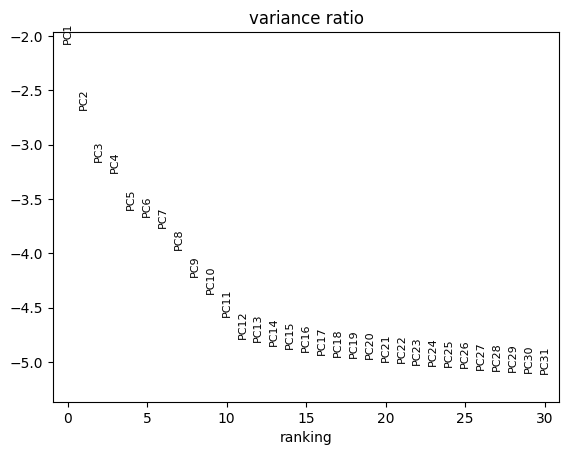

In [16]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=25)

In [18]:
sc.tl.umap(adata)

In [19]:
sc.tl.leiden(adata,resolution=0.2)

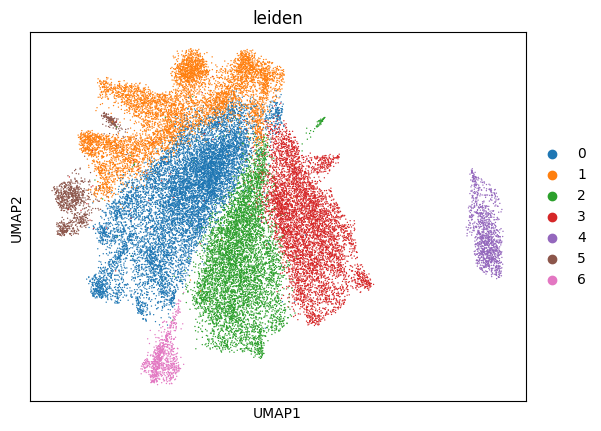

In [20]:
sc.pl.umap(adata, color='leiden')

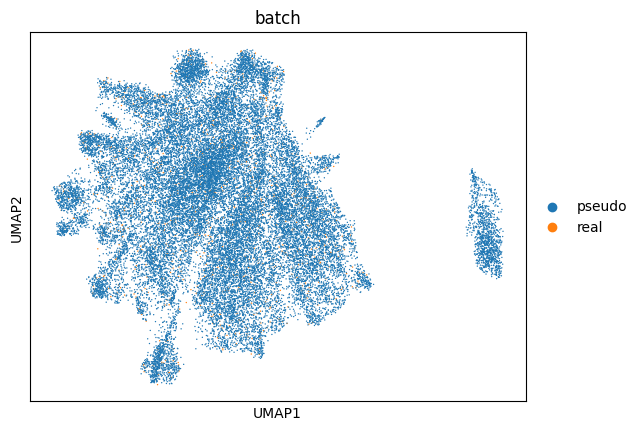

In [21]:
sc.pl.umap(adata, color='batch')

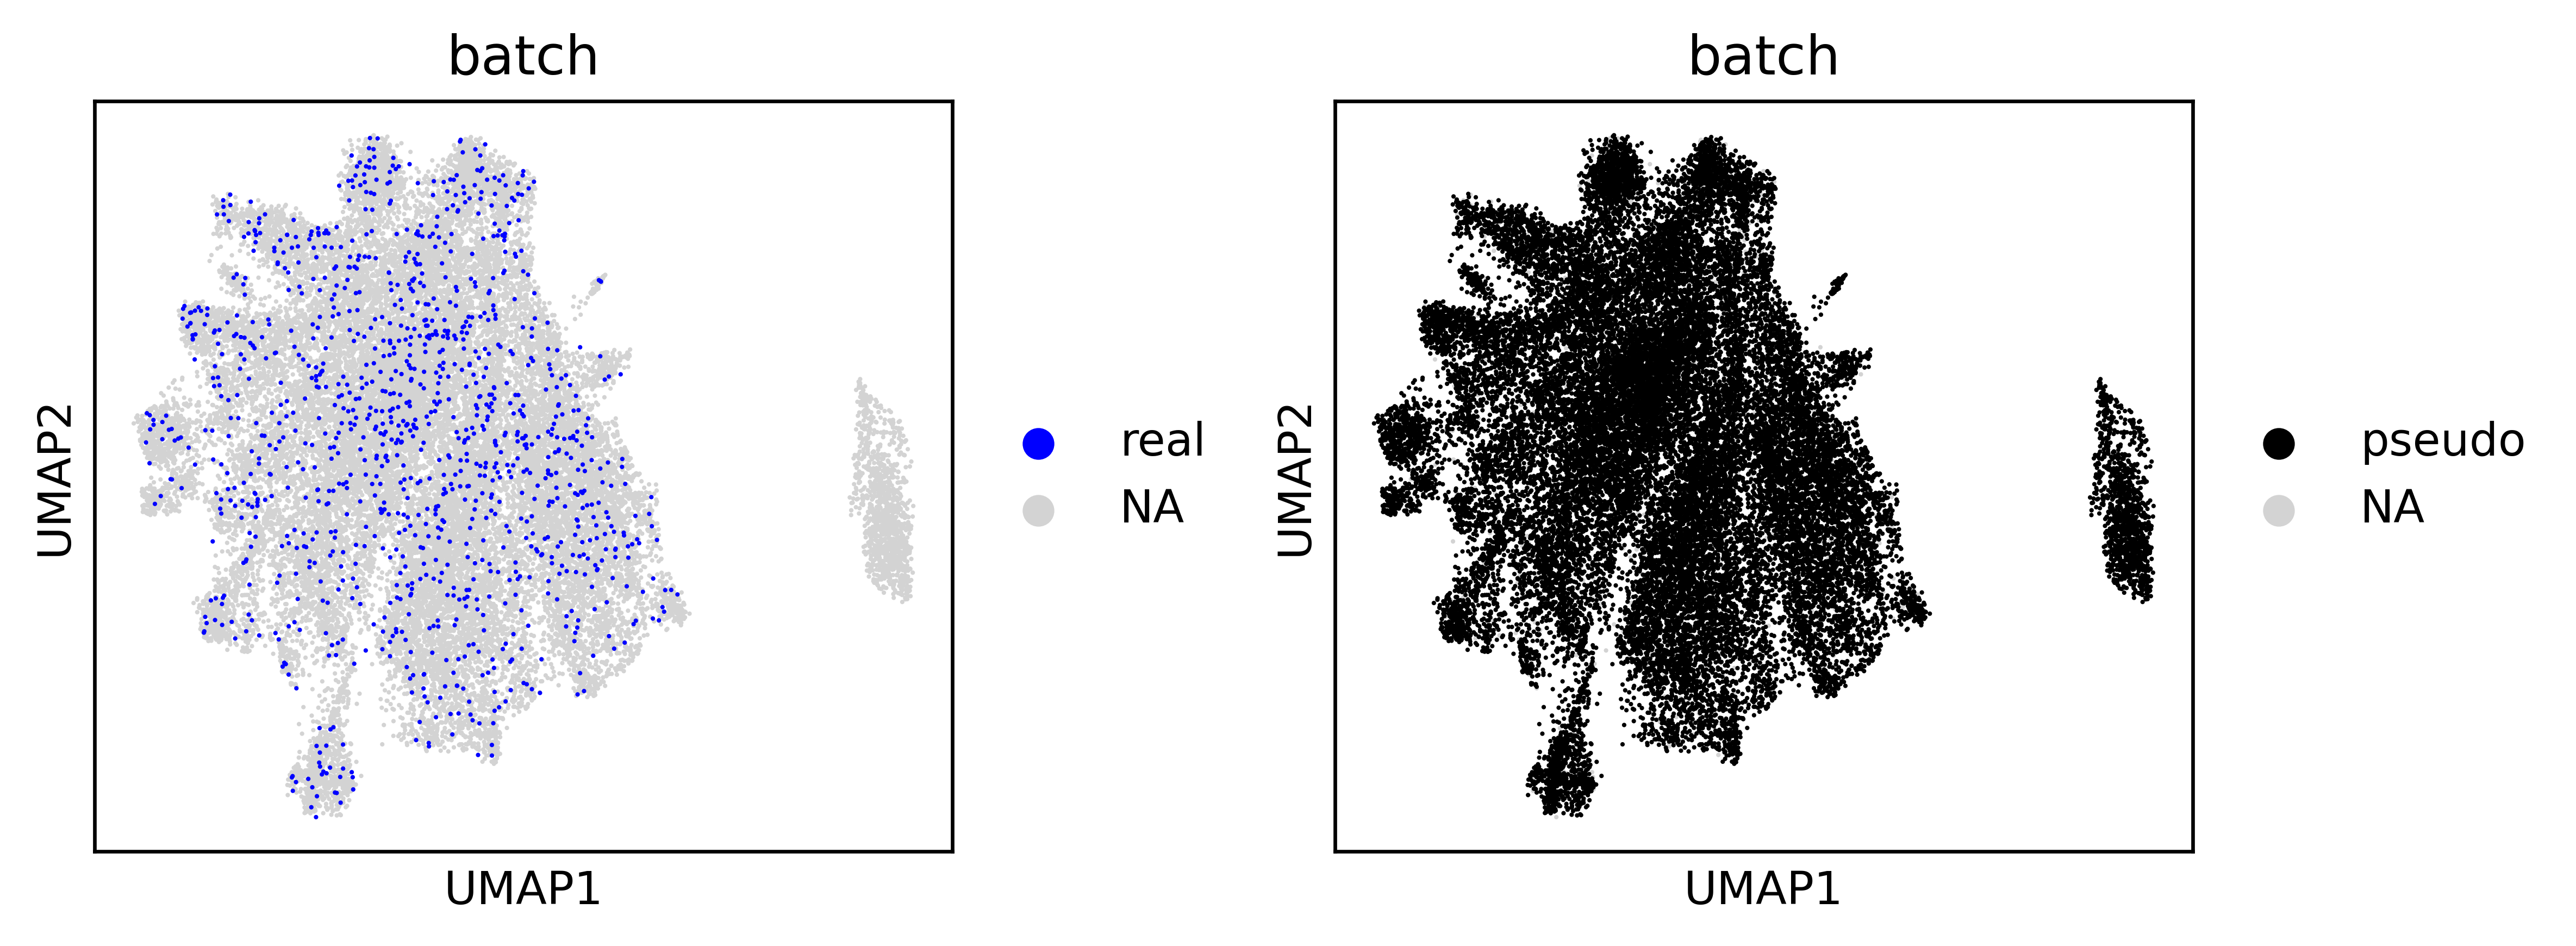

In [22]:
celltype=adata.obs['batch'].unique().tolist() # refined_pred是细胞注释
fig, axes = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True,dpi=600) # nrows和ncols取决于想要的画图个数
x=0;y=0
for i in celltype: #celltype为任何需要并列绘制的list
    fig = sc.pl.umap(adata, color='batch', groups=i, ax=axes[y],show=False,palette=['black','blue'])
    y = y +1 if y <2 else y
    # x = x +1 if x <1 else 0
    # y = y +1 if y <2 and x ==0 else y
plt.show()
plt.close()

In [69]:
adata_real = adata[adata.obs.leiden=='4']

In [ ]:
adata[adata.obsm.]

In [107]:
st_loc_df = pd.DataFrame(st_adata.obsm['X_umap'])
st_loc_df.columns = ['x','y']
st_loc_df.index = st_deconv_df.index

In [108]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

DefaulfColorPalette = [
    "#E58606", "#5D69B1", "#52BCA3", "#99C945", "#CC61B0", "#24796C",
    "#DAA51B", "#2F8AC4", "#764E9F", "#ED645A", "#9EB4C7", "#BCBD22",
    "#B279A2", "#EECA3B", "#17BECF", "#FF9DA6", "#778AAE", "#1B9E77",
    "#A6761D", "#526A83", "#B82E2E", "#80B1D3", "#68855C", "#D95F02",
    "#BEBADA", "#AF6458", "#D9AF6B", "#9C9C5E", "#625377", "#8C785D",
    "#88CCEE", "#E73F74", "#FFFFB3", "#CCEBC5", "#332288", "#A65628"
]


def PieMarker(loc_list, frac_list, size, color_list):
    '''
    Return marker list for a point
    '''
    frac_cumsum = np.cumsum(frac_list)
    frac_cumsum = frac_cumsum/frac_cumsum[-1]
    marker_list = []
    previous = 0
    # calculate the points of the pie pieces
    for color, frac in zip(color_list, frac_cumsum):
        curr = frac
        x  = np.cos(2 * np.pi * np.linspace(previous, curr, 50)).tolist()
        y  = np.sin(2 * np.pi * np.linspace(previous, curr, 50)).tolist()
        xy = np.row_stack([[0, 0], np.column_stack([x, y])])
        marker_list.append({'marker': xy, 's': size*np.abs(xy).max()**2, 'facecolor': color, 'edgecolor': "darkgrey", 'linewidth': 0.1})
        previous = frac
    # scatter each of the pie pieces to create pies
    point_marker_list = []
    for marker in marker_list:
        point_marker_list.append(loc_list + [marker])
    return(point_marker_list)

In [109]:
color_pal = DefaulfColorPalette
pt_size=12
fig = plt.figure()
ax = fig.add_subplot()
for i in st_deconv_df.index:
    deconv_list = st_deconv_df.loc[i,:]
    loc_list = st_loc_df.loc[i,:].tolist()
    point_marker_list = PieMarker(loc_list[0:2], deconv_list, pt_size**2, color_pal)
    for point_marker in point_marker_list:
        ax.scatter(point_marker[0], point_marker[1], **point_marker[-1])
# add legends
celltypes = st_deconv_df.columns
patch_list = []
for i in range(len(celltypes)):
    patch_list.append(mpatches.Patch(facecolor = color_pal[i], 
                                     label = celltypes[i], edgecolor = "darkgrey", 
                                     linewidth=0.1))
ax.legend(handles = patch_list, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'small', frameon = False,
    handlelength=1, handleheight=1)
ax.axis('equal')
ax.set_xlabel(st_loc_df.columns[0])
ax.set_ylabel(st_loc_df.columns[1])
ax.set_title(out_prefix, pad = 15)
# save figure
plot_file = os.path.join(paths['output_path'], "%s_deconv_scatterpie_plot.pdf" %(out_prefix))
fig.savefig(plot_file, bbox_inches = "tight")
plt.close(fig)

### preprocess ###

In [6]:
# print(sc_adata.shape)
# print(st_adata.shape)read_table

In [ ]:
# sc_label = pd.read_table(sc_path+"/sc_label.tsv", sep = '\t', header = 0, index_col = 0, encoding = "utf-8")
# #sc_label.bio_celltype.value_count()
# sc_label.loc[sc_label.bio_celltype=='Mature oligodendrocyte','bio_celltype'] = 'Mature_oligodendrocyte'
# sc_label.loc[sc_label.bio_celltype=='Immature oligodendrocyte','bio_celltype'] = 'Immature_oligodendrocyte'
# sc_label.to_csv(sc_path+"/sc_label.tsv", sep = '\t')

In [ ]:
# var = []
# for i in st_adata.columns:
#     if i == "4732456N10Rik":
#         i='Krt90'
#     var.append(i)
# st_adata.columns =var

In [ ]:
# common_gene = list(set(st_adata.columns) &set(sc_adata.columns))
# print(len(common_gene))
# sc_adata =sc_adata.loc[:,common_gene]
# sc_adata.to_csv(paths['sc_path']+"/MERFISH_ID{0}_{1}_sc_data.tsv".format(idx1,idx2), sep='\t')

### run ###

In [7]:
fraction_pie_plot = True
cell_type_distribution_plot = True
n_jobs = -1
GCN_device = 'GPU'

sc_path = paths['sc_path']
ST_path = paths['ST_path']
output_path = paths['output_path']

# ID= 'ID'+str(idx1)
# Bregma = str(idx2)
sc_adata = sc.read_csv(sc_path+"/MERFISH_ID{0}_{1}_sc_data.tsv".format(idx1,idx2), delimiter='\t')
sc_label = pd.read_table(sc_path+"/sc_label.tsv", sep = '\t', header = 0, index_col = 0, encoding = "utf-8")
sc_label.columns = ['cell_type']
sc_adata.obs['cell_type'] = sc_label['cell_type'].values

cell_type_num = len(sc_adata.obs['cell_type'].unique())
cell_types = sc_adata.obs['cell_type'].unique()

word_to_idx_celltype = {word: i for i, word in enumerate(cell_types)}
idx_to_word_celltype = {i: word for i, word in enumerate(cell_types)}

celltype_idx = [word_to_idx_celltype[w] for w in sc_adata.obs['cell_type']]
sc_adata.obs['cell_type_idx'] = celltype_idx
sc_adata.obs['cell_type'].value_counts()

if use_marker_genes == True:
    if external_genes == True:
        with open(output_path+"/marker_genes.tsv", 'r') as f:
            selected_genes = [line.rstrip('\n') for line in f]
    else:
        selected_genes, cell_type_marker_genes = find_marker_genes(sc_adata,
                                                                  preprocess = find_marker_genes_paras['preprocess'],
                                                                  highly_variable_genes = find_marker_genes_paras['highly_variable_genes'],
                                                                  PCA_components = find_marker_genes_paras['PCA_components'], 
                                                                  filter_wilcoxon_marker_genes = find_marker_genes_paras['filter_wilcoxon_marker_genes'], 
                                                                  marker_gene_method = find_marker_genes_paras['marker_gene_method'],
                                                                  pvals_adj_threshold = find_marker_genes_paras['pvals_adj_threshold'],
                                                                  log_fold_change_threshold = find_marker_genes_paras['log_fold_change_threshold'],
                                                                  min_within_group_fraction_threshold = find_marker_genes_paras['min_within_group_fraction_threshold'],
                                                                  max_between_group_fraction_threshold = find_marker_genes_paras['max_between_group_fraction_threshold'],
                                                                  top_gene_per_type = find_marker_genes_paras['top_gene_per_type'])
        with open(output_path+"/MERFISH_ID{0}_{1}_marker_genes.tsv".format(idx1,idx2), 'w') as f:
            for gene in selected_genes:
                f.write(str(gene) + '\n')
print("{} genes have been selected as marker genes.".format(len(selected_genes)))

154 genes have been selected as marker genes.


In [16]:
output_path

'/data/lyx/hubs/SpaTD/stdgcn/benchmark/MERFISH/ID1/Bregma0.01/'

In [9]:
generate_new_pseudo_spots = False
if generate_new_pseudo_spots == True:
    pseudo_adata = pseudo_spot_generation(sc_adata,
                                          idx_to_word_celltype,
                                          spot_num = pseudo_spot_simulation_paras['spot_num'],
                                          min_cell_number_in_spot = pseudo_spot_simulation_paras['min_cell_num_in_spot'],
                                          max_cell_number_in_spot = pseudo_spot_simulation_paras['max_cell_num_in_spot'],
                                          max_cell_types_in_spot = pseudo_spot_simulation_paras['max_cell_types_in_spot'],
                                          generation_method = pseudo_spot_simulation_paras['generation_method'],
                                          n_jobs = n_jobs
                                          )
    data_file = open(output_path+'/pseudo_ST.pkl','wb')
    pickle.dump(pseudo_adata, data_file)
    data_file.close()
else:
    data_file = open(output_path+'/pseudo_ST_ID1_8_12_4.pkl','rb')
    pseudo_adata = pickle.load(data_file)
    data_file.close()
ST_adata = sc.read_csv(ST_path+"/MERFISH_ID{0}_{1}_data_{2}.tsv".format(idx1,res,idx2), delimiter='\t')
ST_coor = pd.read_table(ST_path+"/MERFISH_ID{0}_{1}_coordinates_{2}.tsv".format(idx1,res,idx2), sep = ',', header = 0, index_col = 0, encoding = "utf-8")
ST_adata.obs['coor_X'] = ST_coor['x']
ST_adata.obs['coor_Y'] = ST_coor['y']
if load_test_groundtruth == True:
    ST_groundtruth = pd.read_table(ST_path+"/ST_ground_truth.tsv", sep = '\t', header = 0, index_col = 0, encoding = "utf-8")
    for i in cell_types:
        ST_adata.obs[i] = ST_groundtruth[i]

ST_genes = ST_adata.var.index.values
pseudo_genes = pseudo_adata.var.index.values
common_genes = set(ST_genes).intersection(set(pseudo_genes))
ST_adata_filter = ST_adata[:,list(common_genes)]
pseudo_adata_filter = pseudo_adata[:,list(common_genes)]

In [10]:
#真spot的adata
ST_adata_filter_norm = ST_preprocess(ST_adata_filter, 
                                     normalize = data_normalization_paras['normalize'], 
                                     log = data_normalization_paras['log'], 
                                     scale = data_normalization_paras['scale'],
                                    )[:,selected_genes]
# adata = ST_adata_filter.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata.layers['scale.data'] = adata.X.copy()


try:
    try:
        ST_adata_filter_norm.obs.insert(0, 'cell_num', ST_adata_filter.obs['cell_num'])
    except:
        ST_adata_filter_norm.obs['cell_num'] = ST_adata_filter.obs['cell_num']
except:
    ST_adata_filter_norm.obs.insert(0, 'cell_num', [0]*ST_adata_filter_norm.obs.shape[0])
for i in cell_types:
    try:
        ST_adata_filter_norm.obs[i] = ST_adata_filter.obs[i]
    except:
        ST_adata_filter_norm.obs[i] = [0]*ST_adata_filter_norm.obs.shape[0]
try:
    ST_adata_filter_norm.obs['cell_type_num'] = (ST_adata_filter_norm.obs[cell_types]>0).sum(axis=1)
except:
    ST_adata_filter_norm.obs['cell_type_num'] = [0]*ST_adata_filter_norm.obs.shape[0]

# 假spot的adata
pseudo_adata_norm = ST_preprocess(pseudo_adata_filter, 
                                  normalize = data_normalization_paras['normalize'], 
                                  log = data_normalization_paras['log'], 
                                  scale = data_normalization_paras['scale'],
                                 )[:,selected_genes]

pseudo_adata_norm.obs['cell_type_num'] = (pseudo_adata_norm.obs[cell_types]>0).sum(axis=1)


# 这里显性地进行了批次矫正，topic模型本来具有一定的抗批次效应，是否需要在这里做一些改进？

ST_integration = data_integration(ST_adata_filter_norm, 
                                  pseudo_adata_norm, 
                                  batch_removal_method = integration_for_adj_paras['batch_removal_method'], 
                                  dim = min(integration_for_adj_paras['dim'], int(ST_adata_filter_norm.shape[1]/2)), 
                                  dimensionality_reduction_method=integration_for_adj_paras['dimensionality_reduction_method'],
                                  scale=integration_for_adj_paras['scale'],
                                  cpu_num=n_jobs,
                                  AE_device=GCN_device
                                  )

In [11]:
print(len(selected_genes))

154


In [12]:
def LDA(sc_corpus, ntopics, genes_dict, genes_shared, cell_gene_list, sc_count_cells, cell_celltype_list, model_dir):
    print('0.---')
    lda = LdaModel(corpus = sc_corpus, num_topics = ntopics, id2word = genes_dict)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics))
    lda.save(model_file)
    # compute the coherence
    print('1.compute the coherence')
    cm = CoherenceModel(model = lda, corpus = sc_corpus, coherence='u_mass')
    umass_coherence = cm.get_coherence()
    cm = CoherenceModel(model = lda, corpus = sc_corpus, texts = cell_gene_list, coherence='c_v')
    cv_coherence = cm.get_coherence()
    # save the topic-cell matrix
    print('2.save the topic-cell matrix')
    topic_cell = lda.get_document_topics(sc_corpus)
    topic_cell_mat = gensim.matutils.corpus2csc(topic_cell)
    topic_cell_file = os.path.join(model_dir, "topic_cell_mat_%s.npz" %(ntopics))
    topic_cell_df_file = os.path.join(model_dir, "topic_cell_mat_%s.txt" %(ntopics))
    scipy.sparse.save_npz(topic_cell_file, topic_cell_mat)
    topic_cell_df = pd.DataFrame(topic_cell_mat.todense(), 
        index = ["Topic %s" %i for i in range(1, 1 + topic_cell_mat.shape[0])], 
        columns = sc_count_cells)
    topic_cell_df.to_csv(topic_cell_df_file, sep = "\t", index = True, header = True)
    # save the gene-topic matrix
    print('3.save the gene-topic matrix')
    topic_gene_mat_list = lda.get_topics()
    topic_gene_mat = np.array(topic_gene_mat_list)
    gene_topic_mat = topic_gene_mat.transpose()
    gene_topic_mat_list = gene_topic_mat.tolist()
    gene_topic_file = os.path.join(model_dir, "gene_topic_mat_%s.txt" %(ntopics))
    gene_topic_out = open(gene_topic_file, "w")
    gene_topic_out.write("\t".join(["Topic%s" %i for i in range(1, ntopics + 1)]) + "\n")
    for i in range(len(gene_topic_mat_list)):
        gene_topic_out.write(genes_shared[i] + "\t" + "\t".join([str(j) for j in gene_topic_mat_list[i]]) + "\n")
    gene_topic_out.close()
    # convert topic_cell_mat to topic_celltype_mat
    print('4.convert topic_cell_mat to topic_celltype_mat')
    celltype_topic_dict = {}
    celltype_num_dict = {}
    celltypes = sorted(list(set(cell_celltype_list)))
    for celltype in celltypes:
        celltype_topic_dict[celltype] = [0]*ntopics
        celltype_num_dict[celltype] = 0
    for i in range(topic_cell_mat.shape[1]):
        cell_celltype = cell_celltype_list[i]
        celltype_topic_dict[cell_celltype] = [celltype_topic_dict[cell_celltype][j] + topic_cell_mat[j,i] for j in range(topic_cell_mat.shape[0])]
        celltype_num_dict[cell_celltype] = celltype_num_dict[cell_celltype] + 1
    celltype_topic_mean_dict = {}
    for celltype in celltypes:
        celltype_topic_mean_dict[celltype] = [i/celltype_num_dict[celltype] for i in celltype_topic_dict[celltype]]
    topic_celltype_df = pd.DataFrame(data = celltype_topic_mean_dict)
    topic_celltype_file = os.path.join(model_dir,"topic_celltype_mat_%s.txt" %(ntopics))
    topic_celltype_df.to_csv(topic_celltype_file, sep="\t")
    # return results
    print('5.return results')
    res_dict = {"coherence": [umass_coherence, cv_coherence], 
    "topic_cell_mat": topic_cell_mat, 
    "topic_celltype_df": topic_celltype_df,
    "celltype_num_dict": celltype_num_dict}

    return(res_dict)

In [13]:
def scLDA(sc_count_mat, sc_count_genes, sc_count_cells, cell_celltype_dict,
          st_count_mat, st_count_genes, st_count_spots,
          normalize, gene_use, ntopics_list, out_dir):
    sc_count_genes_array = np.array(sc_count_genes)
    sc_count_genes_sorter = np.argsort(sc_count_genes_array)
    if normalize:
        sc_count_mat = StandardScaler(with_mean=False).fit_transform(sc_count_mat.transpose()).transpose()
    if gene_use == "All":
        genes_shared = list(set(st_count_genes) & set(sc_count_genes))
    else:
        genes_shared = list(set(st_count_genes) & set(sc_count_genes) & set(gene_use))
    genes_shared = sorted(genes_shared)
    genes_shared_array = np.array(genes_shared)
    genes_shared_index = sc_count_genes_sorter[np.searchsorted(sc_count_genes_array, genes_shared_array, sorter = sc_count_genes_sorter)]
    sc_count_mat_use = sc_count_mat[genes_shared_index,:]
    cell_gene_list = []
    sc_count_mat_use_nonzero = sc_count_mat_use.nonzero()
    for i in range(sc_count_mat_use.shape[1]):
        gene_ind = sc_count_mat_use_nonzero[0][sc_count_mat_use_nonzero[1] == i]
        genes = genes_shared_array[gene_ind].tolist()
        cell_gene_list.append(genes)
        # evaluate the model
    # construct single-cell gene corpus
    sc_corpus = gensim.matutils.Sparse2Corpus(sc_count_mat_use)
    genes_dict = Dictionary([genes_shared])
    genes_dict_file = os.path.join(out_dir, "Gene_dict.txt")
    genes_dict.save_as_text(genes_dict_file)
    cell_celltype_list = []
    for i in range(len(sc_count_cells)):
        cell_celltype = cell_celltype_dict[sc_count_cells[i]]
        cell_celltype_list.append(cell_celltype)
    print("Selecting the optimal model.")
    model_selection_res = ModelSelect(sc_corpus = sc_corpus, genes_dict = genes_dict, genes_shared = genes_shared,
        ntopics_list = ntopics_list, cell_gene_list = cell_gene_list, sc_count_cells = sc_count_cells, 
        cell_celltype_list = cell_celltype_list, out_dir = out_dir)
    model_selected = model_selection_res["model"]
    ntopics_selected = model_selection_res["ntopics"]

    return({"genes_dict": genes_dict, "model_selected": model_selected, "ntopics_selected": ntopics_selected})

In [14]:
celltypes = set(list(sc_adata.obs['cell_type']))
celltypes
cell_celltype_dict = {}
for index_ in sc_adata.obs['cell_type'].index:
    cell_celltype_dict[index_] = sc_adata.obs['cell_type'][index_]
list(cell_celltype_dict.values())[:3]

['Excitatory', 'Inhibitory', 'Excitatory']

In [ ]:
import os
import scipy
import gensim
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp_sparse

from sklearn.preprocessing import StandardScaler
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

from STdGCN.utility.IO import read_10X_h5, read_count, write_10X_h5
from STdGCN.ModelEvaluate import *
from STdGCN.ModelTrain import ModelSelect

sc_count_scale_mat = scipy.sparse.csc_matrix(sc_adata.X.T) #需要使用稀疏格式 csc
sc_count_genes = selected_genes
sc_count_cells = list(sc_adata.obs['cell_type'].index)
# cell_celltype_dict
st_count_mat = scipy.sparse.csc_matrix(ST_adata_filter_norm.X.T)
st_count_genes = selected_genes
st_count_spots = ST_adata_filter_norm.obs['cell_num'].index.tolist()
normalize = None # 需要调整
gene_use = selected_genes # stride中从外部导入了marker基因，如何生成的呢？
ntopics_list= [] # 可以设置为一个包含topic数目的列表，比如[4,5,6]；如果设置为[]，会自动从
                # ntopics_list = list(range(len(celltypes), 3*len(celltypes)+1))范围内选取效果最好的主题数目

celltypes = set(list(sc_adata.obs['cell_type']))
#ntopics_list = list(range(20, 3*len(celltypes)+1))
if not ntopics_list:
    ntopics_list = list(range(len(celltypes), 3*len(celltypes)+1))
print("Training topic model...")
lda_res = scLDA(sc_count_scale_mat, sc_count_genes, sc_count_cells, cell_celltype_dict,
                st_count_mat, st_count_genes, st_count_spots,
                normalize, gene_use, ntopics_list, out_dir)
genes_dict = lda_res["genes_dict"]
model_selected = lda_res["model_selected"]
ntopics_selected = lda_res["ntopics_selected"]
model_dir = os.path.join(out_dir, "model")

Training topic model...
Selecting the optimal model.
Number of topics: 10
start LDA
finish LDA
Number of topics: 11
start LDA
finish LDA


In [17]:
lda_res

{'genes_dict': <gensim.corpora.dictionary.Dictionary at 0x7f455f20b8e0>,
 'model_selected': 'BayesNorm',
 'ntopics_selected': 26}

In [21]:
#dictionary.save('/tmp/deerwester.dict') 
#dictionary.load('/tmp/deerwester.dict')
#corpora.MmCorpus.serialize(‘vector.mm’,corpus) 
#加载mm文件 
#corpus=corpora.MmCorpus(‘vector.mm’)
# genes_dict = Dictionary.load(os.path.join("topic_output", "Gene_dict.txt"))
# model_selected = 'BayesNorm'
# ntopics_selected = 26
# model_dir = os.path.join("topic_output", "model")

In [18]:
# 从SpatialDeconvolve函数修改得到
def GetRealSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, ntopics_selected, normalize, out_dir, model_dir, out_prefix):
    st_count_genes_array = np.array(st_count_genes) # gene为行，cell/spot为列
    st_count_genes_sorter = np.argsort(st_count_genes_array) # 对每列进行从小到大排序，记录序号
    if normalize:
        st_count_mat = StandardScaler(with_mean=False).fit_transform(st_count_mat.transpose()).transpose()
    genes_dict_token2id = genes_dict.token2id
    genes_shared = list(set(st_count_genes) & set(list(genes_dict_token2id.keys())))
    genes_shared = sorted(genes_shared)
    genes_shared_array = np.array(genes_shared)
    genes_shared_index = st_count_genes_sorter[np.searchsorted(st_count_genes_array, genes_shared_array, sorter = st_count_genes_sorter)]
    st_count_mat_use = st_count_mat[genes_shared_index,:]
    st_corpus = []
    for i in range(st_count_mat_use.shape[1]):
    # for i in range(2):
        st_genes_nonzero_index = np.nonzero(st_count_mat_use[:,i])[0]
        # print(st_genes_nonzero_index[0:10])
        st_genes_nonzero = genes_shared_array[st_genes_nonzero_index]
        st_genes_nonzero_index_corpus = [genes_dict_token2id[i] for i in st_genes_nonzero]
        # print(st_genes_nonzero_index_corpus[0:10])
        st_genes_nonzero_count = st_count_mat_use[st_genes_nonzero_index, i].toarray().flatten().tolist()
        st_corpus.append(list(zip(st_genes_nonzero_index_corpus, st_genes_nonzero_count)))
    topic_spot_file = os.path.join(out_dir, "%s_topic_real_spot_mat_%s.npz" %(out_prefix, ntopics_selected))
    topic_spot_df_file = os.path.join(out_dir, "%s_topic_real_spot_mat_%s.txt" %(out_prefix, ntopics_selected))

    model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics_selected))
    lda = LdaModel.load(model_file)
    topic_spot = lda.get_document_topics(st_corpus)
    topic_spot_mat = gensim.matutils.corpus2csc(topic_spot)
    scipy.sparse.save_npz(topic_spot_file, topic_spot_mat)
    topic_spot_df = pd.DataFrame(topic_spot_mat.todense(), 
        index = ["Topic %s" %i for i in range(1, 1 + topic_spot_mat.shape[0])], 
        columns = st_count_spots)
    topic_spot_df.to_csv(topic_spot_df_file, sep = "\t", index = True, header = True)
        
    # 若存在topic_spot_mat，不在重新生成
    # if os.path.exists(topic_spot_file):
    #     topic_spot_mat = scipy.sparse.load_npz(topic_spot_file)
    # else:
    #     model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics_selected))
    #     lda = LdaModel.load(model_file)
    #     topic_spot = lda.get_document_topics(st_corpus)
    #     topic_spot_mat = gensim.matutils.corpus2csc(topic_spot)
    #     scipy.sparse.save_npz(topic_spot_file, topic_spot_mat)
    #     topic_spot_df = pd.DataFrame(topic_spot_mat.todense(), 
    #         index = ["Topic %s" %i for i in range(1, 1 + topic_spot_mat.shape[0])], 
    #         columns = st_count_spots)
    #     topic_spot_df.to_csv(topic_spot_df_file, sep = "\t", index = True, header = True)
        
    # 这是stride中用于比例分解的代码
    # if model_selected == "Raw":
    #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveRaw(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
    # if model_selected == "Norm":
    #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveNorm(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
    # if model_selected == "NormBySD":
    #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveNormBySD(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
    # if model_selected == "Bayes":
    #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveBayes(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
    # if model_selected == "BayesNorm":
    #     spot_celltype_array_df, spot_celltype_array_norm_df = SpatialDeconvolveBayesNorm(st_count_spots, ntopics_selected, topic_spot_mat, out_dir, model_dir)
    # spot_celltype_array_norm_df_file = os.path.join(out_dir, "%s_spot_celltype_frac.txt" %(out_prefix))
    # spot_celltype_array_norm_df.to_csv(spot_celltype_array_norm_df_file, sep = "\t")
    # return(spot_celltype_array_norm_df)
    return topic_spot_df

def GetPseudoSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, ntopics_selected, normalize, out_dir, model_dir, out_prefix):
    st_count_genes_array = np.array(st_count_genes) # gene为行，cell/spot为列
    st_count_genes_sorter = np.argsort(st_count_genes_array) # 对每列进行从小到大排序，记录序号
    if normalize:
        st_count_mat = StandardScaler(with_mean=False).fit_transform(st_count_mat.transpose()).transpose()
    genes_dict_token2id = genes_dict.token2id
    genes_shared = list(set(st_count_genes) & set(list(genes_dict_token2id.keys())))
    genes_shared = sorted(genes_shared)
    genes_shared_array = np.array(genes_shared)
    genes_shared_index = st_count_genes_sorter[np.searchsorted(st_count_genes_array, genes_shared_array, sorter = st_count_genes_sorter)]
    st_count_mat_use = st_count_mat[genes_shared_index,:]
    st_corpus = []
    for i in range(st_count_mat_use.shape[1]):
    # for i in range(2):
        st_genes_nonzero_index = np.nonzero(st_count_mat_use[:,i])[0]
        # print(st_genes_nonzero_index[0:10])
        st_genes_nonzero = genes_shared_array[st_genes_nonzero_index]
        st_genes_nonzero_index_corpus = [genes_dict_token2id[i] for i in st_genes_nonzero]
        # print(st_genes_nonzero_index_corpus[0:10])
        st_genes_nonzero_count = st_count_mat_use[st_genes_nonzero_index, i].toarray().flatten().tolist()
        st_corpus.append(list(zip(st_genes_nonzero_index_corpus, st_genes_nonzero_count)))
    topic_spot_file = os.path.join(out_dir, "%s_topic_pseudo_spot_mat_%s.npz" %(out_prefix, ntopics_selected))
    topic_spot_df_file = os.path.join(out_dir, "%s_topic_pseudo_spot_mat_%s.txt" %(out_prefix, ntopics_selected))

    model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics_selected))
    lda = LdaModel.load(model_file)
    topic_spot = lda.get_document_topics(st_corpus)
    topic_spot_mat = gensim.matutils.corpus2csc(topic_spot)
    scipy.sparse.save_npz(topic_spot_file, topic_spot_mat)
    topic_spot_df = pd.DataFrame(topic_spot_mat.todense(), 
        index = ["Topic %s" %i for i in range(1, 1 + topic_spot_mat.shape[0])], 
        columns = st_count_spots)
    topic_spot_df.to_csv(topic_spot_df_file, sep = "\t", index = True, header = True)
    return topic_spot_df

def GetIntegrationSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, ntopics_selected, normalize, out_dir, model_dir, out_prefix):
    st_count_genes_array = np.array(st_count_genes) # gene为行，cell/spot为列
    st_count_genes_sorter = np.argsort(st_count_genes_array) # 对每列进行从小到大排序，记录序号
    if normalize:
        st_count_mat = StandardScaler(with_mean=False).fit_transform(st_count_mat.transpose()).transpose()
    genes_dict_token2id = genes_dict.token2id
    genes_shared = list(set(st_count_genes) & set(list(genes_dict_token2id.keys())))
    genes_shared = sorted(genes_shared)
    genes_shared_array = np.array(genes_shared)
    genes_shared_index = st_count_genes_sorter[np.searchsorted(st_count_genes_array, genes_shared_array, sorter = st_count_genes_sorter)]
    st_count_mat_use = st_count_mat[genes_shared_index,:]
    st_corpus = []
    for i in range(st_count_mat_use.shape[1]):
    # for i in range(2):
        st_genes_nonzero_index = np.nonzero(st_count_mat_use[:,i])[0]
        # print(st_genes_nonzero_index[0:10])
        st_genes_nonzero = genes_shared_array[st_genes_nonzero_index]
        st_genes_nonzero_index_corpus = [genes_dict_token2id[i] for i in st_genes_nonzero]
        # print(st_genes_nonzero_index_corpus[0:10])
        st_genes_nonzero_count = st_count_mat_use[st_genes_nonzero_index, i].toarray().flatten().tolist()
        st_corpus.append(list(zip(st_genes_nonzero_index_corpus, st_genes_nonzero_count)))
    topic_spot_file = os.path.join(out_dir, "%s_topic_integration_spot_mat_%s.npz" %(out_prefix, ntopics_selected))
    topic_spot_df_file = os.path.join(out_dir, "%s_topic_integration_spot_mat_%s.txt" %(out_prefix, ntopics_selected))

    model_file = os.path.join(model_dir, "lda_model_%s" %(ntopics_selected))
    lda = LdaModel.load(model_file)
    topic_spot = lda.get_document_topics(st_corpus)
    topic_spot_mat = gensim.matutils.corpus2csc(topic_spot)
    scipy.sparse.save_npz(topic_spot_file, topic_spot_mat)
    topic_spot_df = pd.DataFrame(topic_spot_mat.todense(), 
        index = ["Topic %s" %i for i in range(1, 1 + topic_spot_mat.shape[0])], 
        columns = st_count_spots)
    topic_spot_df.to_csv(topic_spot_df_file, sep = "\t", index = True, header = True)
    return topic_spot_df

In [19]:
st_count_mat = scipy.sparse.csc_matrix(ST_adata_filter_norm.X.T)
st_count_genes = selected_genes
st_count_spots = ST_adata_filter_norm.obs['cell_num'].index.tolist()
normalize = None # 需要调整
gene_use = selected_genes # stride中从外部导入了marker基因，如何生成的呢？
ntopics_list= [] # 将来作为输入参数
out_dir = "./topic_output"
out_prefix = "MERFISH_ID1_0.01"

topic_real_spot_df = GetRealSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, 
                                      ntopics_selected, normalize, out_dir, model_dir, out_prefix)

In [20]:
st_count_mat = scipy.sparse.csc_matrix(pseudo_adata_norm.X.T)
st_count_genes = selected_genes
st_count_spots = pseudo_adata_norm.obs['cell_num'].index.tolist()
normalize = None # 需要调整
gene_use = selected_genes # stride中从外部导入了marker基因，如何生成的呢？
ntopics_list= [] # 将来作为输入参数
out_dir = "./topic_output"
out_prefix = "MERFISH_ID1_0.01"

topic_pseudo_spot_df = GetPseudoSpotTopic(st_count_mat, st_count_genes, st_count_spots, genes_dict, model_selected, 
                                      ntopics_selected, normalize, out_dir, model_dir, out_prefix)

In [21]:
ST_integration_topic = pd.concat([ST_integration.iloc[:,:3],pd.concat([topic_real_spot_df.T,topic_pseudo_spot_df.T], axis=0)], axis=1)
ST_integration_topic

,ST_type,cell_num,cell_type_num,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,...,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26
gr_1096,real,0.0,0,0.058863,0.000000,0.000000,0.041046,0.000000,0.000000,0.0,...,0.000000,0.035992,0.0,0.094622,0.0,0.235866,0.0,0.122084,0.114194,0.000000
gr_812,real,0.0,0,0.075881,0.000000,0.000000,0.047690,0.000000,0.012113,0.0,...,0.016061,0.027547,0.0,0.171716,0.0,0.182790,0.0,0.090916,0.115669,0.000000
gr_954,real,0.0,0,0.086655,0.011001,0.000000,0.057562,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.116987,0.0,0.243843,0.0,0.167770,0.109232,0.000000
gr_670,real,0.0,0,0.067885,0.010904,0.000000,0.000000,0.000000,0.033958,0.0,...,0.000000,0.011883,0.0,0.073509,0.0,0.256120,0.0,0.093500,0.077148,0.000000
gr_1097,real,0.0,0,0.066889,0.014010,0.000000,0.065759,0.000000,0.000000,0.0,...,0.000000,0.016948,0.0,0.082317,0.0,0.232526,0.0,0.103506,0.124539,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,pseudo,11.0,3,0.000000,0.000000,0.011877,0.041740,0.045793,0.000000,0.0,...,0.000000,0.024357,0.0,0.296911,0.0,0.160563,0.0,0.107825,0.036532,0.014096
29996,pseudo,12.0,4,0.039287,0.000000,0.013564,0.000000,0.025540,0.000000,0.0,...,0.000000,0.021734,0.0,0.286157,0.0,0.144567,0.0,0.106529,0.091413,0.000000
29997,pseudo,10.0,2,0.113380,0.000000,0.000000,0.027837,0.000000,0.000000,0.0,...,0.000000,0.023703,0.0,0.233916,0.0,0.206896,0.0,0.111224,0.066492,0.000000
29998,pseudo,8.0,2,0.027687,0.000000,0.016766,0.000000,0.000000,0.000000,0.0,...,0.000000,0.051329,0.0,0.398771,0.0,0.112126,0.0,0.149086,0.104090,0.029455


In [22]:
import anndata as ad
ST_adata_filter_norm_topic=ad.AnnData(topic_real_spot_df.T.values,obs=ST_adata_filter_norm.obs)
ST_adata_filter_norm_topic

AnnData object with n_obs × n_vars = 1193 × 26
    obs: 'cell_num', 'coor_X', 'coor_Y', 'Excitatory', 'Inhibitory', 'Mature_oligodendrocyte', 'Endothelial', 'Immature_oligodendrocyte', 'Microglia', 'Ambiguous', 'Mural', 'Astrocyte', 'Ependymal', 'cell_type_num'

In [23]:
pseudo_adata_norm_topic=ad.AnnData(topic_pseudo_spot_df.T.values,obs=pseudo_adata_norm.obs)
pseudo_adata_norm_topic

AnnData object with n_obs × n_vars = 30000 × 26
    obs: 'Excitatory', 'Inhibitory', 'Mature_oligodendrocyte', 'Endothelial', 'Immature_oligodendrocyte', 'Microglia', 'Ambiguous', 'Mural', 'Astrocyte', 'Ependymal', 'cell_num', 'cell_type_num'

In [72]:
# 后续创建表达邻近图的函数，只用了.X
def intra_exp_adj(adata, 
                  find_neighbor_method='KNN', 
                  dist_method='euclidean', 
                  PCA_dimensionality_reduction=True, 
                  dim=50, 
                  corr_dist_neighbors=10, 
                  ):
        
    ST_exp = adata.copy()
    
    sc.pp.scale(ST_exp, max_value=None, zero_center=True)
    if PCA_dimensionality_reduction == True:
        sc.tl.pca(ST_exp, n_comps=dim, svd_solver='arpack', random_state=None)
        input_data = ST_exp.obsm['X_pca']
        if find_neighbor_method == 'KNN':
            if dist_method == 'cosine':
                cos_sim = cosine_similarity(input_data, input_data)
                k_index = torch.topk(torch.tensor(cos_sim), k=corr_dist_neighbors, dim=1)[1]
            else:
                dist = DistanceMetric.get_metric(dist_method)
                k_index = KDTree(input_data, metric=dist).query(input_data, k=corr_dist_neighbors, return_distance=False)
            A_exp = np.zeros((ST_exp.shape[0], ST_exp.shape[0]), dtype=float)
            for i in range(k_index.shape[0]):
                for j in k_index[i]:
                    if i != j:
                        A_exp[i, j] = 1;
                        A_exp[j, i] = 1;  
            A_exp = pd.DataFrame(A_exp, index=ST_exp.obs.index.values, columns=ST_exp.obs.index.values)
        elif find_neighbor_method == 'MNN':
            mut = find_mutual_nn(input_data, input_data, dist_method=dist_method, k1=corr_dist_neighbors, k2=corr_dist_neighbors)
            mut = pd.DataFrame(mut, columns=['data1', 'data2'])
            A_exp = np.zeros((ST_exp.shape[0], ST_exp.shape[0]), dtype=float)
            for i in mut.index:
                A_exp[mut.loc[i, 'data1'], mut.loc[i, 'data2']] = 1
                A_exp[mut.loc[i, 'data2'], mut.loc[i, 'data1']] = 1
            A_exp = A_exp - np.eye(A_exp.shape[0])
            A_exp = pd.DataFrame(A_exp, index=ST_exp.obs.index.values, columns=ST_exp.obs.index.values)     
    else:
        sc.pp.scale(ST_exp, max_value=None, zero_center=True)
        input_data = ST_exp.X
        if find_neighbor_method == 'KNN':
            if dist_method == 'cosine':
                cos_sim = cosine_similarity(input_data, input_data)
                k_index = torch.topk(torch.tensor(cos_sim), k=corr_dist_neighbors, dim=1)[1]
            else:
                dist = DistanceMetric.get_metric(dist_method)
                k_index = KDTree(input_data, metric=dist).query(input_data, k=corr_dist_neighbors, return_distance=False)
            A_exp = np.zeros((ST_exp.shape[0], ST_exp.shape[0]), dtype=float)
            for i in range(k_index.shape[0]):
                for j in k_index[i]:
                    if i != j:
                        A_exp[i, j] = 1;
                        A_exp[j, i] = 1;  
            A_exp = pd.DataFrame(A_exp, index=ST_exp.obs.index.values, columns=ST_exp.obs.index.values)
        elif find_neighbor_method == 'MNN':
            mut = find_mutual_nn(input_data, input_data, dist_method=dist_method, k1=corr_dist_neighbors, k2=corr_dist_neighbors)
            mut = pd.DataFrame(mut, columns=['data1', 'data2'])
            A_exp = np.zeros((ST_exp.shape[0], ST_exp.shape[0]), dtype=float)
            for i in mut.index:
                A_exp[mut.loc[i, 'data1'], mut.loc[i, 'data2']] = 1
                A_exp[mut.loc[i, 'data2'], mut.loc[i, 'data1']] = 1
            A_exp = A_exp - np.eye(A_exp.shape[0])
            A_exp = pd.DataFrame(A_exp, index=ST_exp.obs.index.values, columns=ST_exp.obs.index.values)   
        
    return A_exp

In [24]:
A_inter_exp =  inter_adj(ST_integration_topic, 
                         find_neighbor_method=inter_exp_adj_paras['find_neighbor_method'], 
                         dist_method=inter_exp_adj_paras['dist_method'], 
                         corr_dist_neighbors=inter_exp_adj_paras['corr_dist_neighbors'], 
                        )

A_intra_space = intra_dist_adj(ST_adata_filter_norm_topic, 
                               link_method=spatial_adj_paras['link_method'],
                               space_dist_threshold=spatial_adj_paras['space_dist_threshold'],
                              )

A_real_intra_exp = intra_exp_adj(ST_adata_filter_norm_topic, 
                                 find_neighbor_method=real_intra_exp_adj_paras['find_neighbor_method'], 
                                 dist_method=real_intra_exp_adj_paras['dist_method'],
                                 PCA_dimensionality_reduction=real_intra_exp_adj_paras['PCA_dimensionality_reduction'],
                                 corr_dist_neighbors=real_intra_exp_adj_paras['corr_dist_neighbors'],
                                )

A_pseudo_intra_exp = intra_exp_adj(pseudo_adata_norm_topic, 
                                   find_neighbor_method=pseudo_intra_exp_adj_paras['find_neighbor_method'], 
                                   dist_method=pseudo_intra_exp_adj_paras['dist_method'],
                                   PCA_dimensionality_reduction=pseudo_intra_exp_adj_paras['PCA_dimensionality_reduction'],
                                   corr_dist_neighbors=pseudo_intra_exp_adj_paras['corr_dist_neighbors'],
                                  )

real_num = ST_adata_filter.shape[0]
pseudo_num = pseudo_adata.shape[0]

adj_inter_exp = A_inter_exp.values
adj_pseudo_intra_exp = A_intra_transfer(A_pseudo_intra_exp, 'pseudo', real_num, pseudo_num)
adj_real_intra_exp = A_intra_transfer(A_real_intra_exp, 'real', real_num, pseudo_num)
adj_intra_space = A_intra_transfer(A_intra_space, 'real', real_num, pseudo_num)

adj_alpha = 1
adj_beta = 1
diag_power = 20
adj_balance = (1+adj_alpha+adj_beta)*diag_power
adj_exp = torch.tensor(adj_inter_exp+adj_alpha*adj_pseudo_intra_exp+adj_beta*adj_real_intra_exp)/adj_balance + torch.eye(adj_inter_exp.shape[0])
adj_sp = torch.tensor(adj_intra_space)/diag_power + torch.eye(adj_intra_space.shape[0])

norm = True
if(norm == True):
    adj_exp = torch.tensor(adj_normalize(adj_exp, symmetry=True))
    adj_sp = torch.tensor(adj_normalize(adj_sp, symmetry=True))


ST_integration_batch_removed = data_integration(ST_adata_filter_norm, 
                                                pseudo_adata_norm, 
                                                batch_removal_method=integration_for_feature_paras['batch_removal_method'], 
                                                dim=min(int(ST_adata_filter_norm.shape[1]*1/2), integration_for_feature_paras['dim']), 
                                                dimensionality_reduction_method=integration_for_feature_paras['dimensionality_reduction_method'], 
                                                scale=integration_for_feature_paras['scale'],
                                                cpu_num=n_jobs,
                                                AE_device=GCN_device
                                              )
feature = torch.tensor(ST_integration_topic.iloc[:, 3:].values)#ST_integration_batch_removed


input_layer = feature.shape[1]
hidden_layer = min(int(ST_adata_filter_norm.shape[1]*1/2), GCN_paras['dim'])
output_layer1 = len(word_to_idx_celltype)
epoch_n = GCN_paras['epoch_n']
common_hid_layers_num = GCN_paras['common_hid_layers_num']
fcnn_hid_layers_num = GCN_paras['fcnn_hid_layers_num']
dropout = GCN_paras['dropout']
learning_rate_SGD = GCN_paras['learning_rate_SGD']
weight_decay_SGD = GCN_paras['weight_decay_SGD']
momentum = GCN_paras['momentum']
dampening = GCN_paras['dampening']
nesterov = GCN_paras['nesterov']
early_stopping_patience = GCN_paras['early_stopping_patience']
clip_grad_max_norm = GCN_paras['clip_grad_max_norm']
LambdaLR_scheduler_coefficient = 0.997
ReduceLROnPlateau_factor = 0.1
ReduceLROnPlateau_patience = 5
scheduler = 'scheduler_ReduceLROnPlateau'
print_epoch_step = GCN_paras['print_loss_epoch_step']
cpu_num = n_jobs

model = conGCN(nfeat = input_layer, 
               nhid = hidden_layer, 
               common_hid_layers_num = common_hid_layers_num, 
               fcnn_hid_layers_num = fcnn_hid_layers_num, 
               dropout = dropout, 
               nout1 = output_layer1
              )

optimizer = torch.optim.SGD(model.parameters(), 
                            lr = learning_rate_SGD, 
                            momentum = momentum, 
                            weight_decay = weight_decay_SGD, 
                            dampening = dampening, 
                            nesterov = nesterov)

scheduler_LambdaLR = torch.optim.lr_scheduler.LambdaLR(optimizer, 
                                                       lr_lambda = lambda epoch: LambdaLR_scheduler_coefficient ** epoch)
scheduler_ReduceLROnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                         mode='min', 
                                                                         factor=ReduceLROnPlateau_factor, 
                                                                         patience=ReduceLROnPlateau_patience, 
                                                                         threshold=0.0001, 
                                                                         threshold_mode='rel', 
                                                                         cooldown=0, 
                                                                         min_lr=0)
if scheduler == 'scheduler_LambdaLR':
    scheduler = scheduler_LambdaLR
elif scheduler == 'scheduler_ReduceLROnPlateau':
    scheduler = scheduler_ReduceLROnPlateau
else:
    scheduler = None

loss_fn1 = nn.KLDivLoss(reduction = 'mean')

train_valid_len = pseudo_adata.shape[0]
test_len = ST_adata_filter.shape[0]

table1 = ST_adata_filter_norm.obs.copy()
label1 = table1[pseudo_adata.obs.iloc[:,:-1].columns].append(pseudo_adata.obs.iloc[:,:-1])
label1 = torch.tensor(label1.values)

adjs = [adj_exp.float(), adj_sp.float()]

output1, loss, trained_model = conGCN_train(model = model, 
                                            train_valid_len = train_valid_len,
                                            train_valid_ratio = 0.9,
                                            test_len = test_len, 
                                            feature = feature, 
                                            adjs = adjs, 
                                            label = label1, 
                                            epoch_n = epoch_n, 
                                            loss_fn = loss_fn1, 
                                            optimizer = optimizer, 
                                            scheduler = scheduler, 
                                            early_stopping_patience = early_stopping_patience,
                                            clip_grad_max_norm = clip_grad_max_norm,
                                            load_test_groundtruth = load_test_groundtruth,
                                            print_epoch_step = print_epoch_step,
                                            cpu_num = cpu_num,
                                            GCN_device = GCN_device
                                           )

loss_table = pd.DataFrame(loss, columns=['train', 'valid', 'test'])

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(loss_table.index, loss_table['train'], label='train')
ax.plot(loss_table.index, loss_table['valid'], label='valid')
if load_test_groundtruth == True:
    ax.plot(loss_table.index, loss_table['test'], label='test')
ax.set_xlabel('Epoch', fontsize = 20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_title('Loss function curve', fontsize = 20)
ax.legend(fontsize = 15)
plt.tight_layout()
plt.savefig(output_path+'/Loss_function.jpg', dpi=300)
plt.close('all')

predict_table = pd.DataFrame(np.exp(output1[:test_len].detach().numpy()).tolist(), index=ST_adata_filter_norm.obs.index, columns=pseudo_adata_norm.obs.columns[:-2])
predict_table.to_csv(output_path+'/predict_result.csv', index=True, header=True)

torch.save(trained_model, output_path+'/model_parameters')

pred_use = np.round_(output1.exp().detach()[:test_len], decimals=4)
cell_type_list = cell_types
coordinates = ST_adata_filter_norm.obs[['coor_X', 'coor_Y']]

if fraction_pie_plot == True:
    plot_frac_results(pred_use, cell_type_list, coordinates, point_size=300, size_coefficient=0.0009, file_name=output_path+'/predict_results_pie_plot.jpg', if_show=False)

if cell_type_distribution_plot == True:
    plot_scatter_by_type(pred_use, cell_type_list, coordinates, point_size=300, file_path=output_path, if_show=False)

ST_adata_filter_norm.obsm['predict_result'] = np.exp(output1[:test_len].detach().numpy())

torch.cuda.empty_cache()

Use GPU as device.
******************************************
Epoch 1/3000 loss_train: 0.1728 loss_val: 0.1726	time: 1.1525s
******************************************
Epoch 21/3000 loss_train: 0.0862 loss_val: 0.0861	time: 3.4116s
******************************************
Epoch 41/3000 loss_train: 0.0800 loss_val: 0.0804	time: 5.5947s
******************************************
Epoch 61/3000 loss_train: 0.0778 loss_val: 0.0784	time: 7.9320s
******************************************
Epoch 81/3000 loss_train: 0.0765 loss_val: 0.0773	time: 10.3059s
******************************************
Epoch 101/3000 loss_train: 0.0756 loss_val: 0.0765	time: 12.6136s
******************************************
Epoch 121/3000 loss_train: 0.0749 loss_val: 0.0760	time: 14.8983s
******************************************
Epoch 141/3000 loss_train: 0.0743 loss_val: 0.0755	time: 17.4008s
******************************************
Epoch 161/3000 loss_train: 0.0738 loss_val: 0.0752	time: 19.8230s
**********

Plotting pie plots::   0%|          | 0/1193 [00:00<?, ?it/s]

Plotting cell type scatter plot::   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
import numpy as np
import scipy.stats as ss

def JS_divergence(p,q):
    M = (p+q)/2
    return 0.5 * ss.entropy(p,M,base=2) + 0.5*ss.entropy(q,M,base=2)

# 矩阵按行求JSD,
def JS_divergence_mat(p_mat, q_mat):
    raw = p_mat.shape[0]
    jsd = 0
    for i in range(raw):
        jsd += JS_divergence(p_mat.iloc[i], q_mat.iloc[i])
    return jsd

In [10]:
import pandas as pd
#pred_proportion= pd.read_csv('./benchmark/MERFISH/ID1/Bregma0.01/predict_result.csv',index_col=0)
#pred_proportion= pd.read_csv('./benchmark/MERFISH/ID1/Bregma0.01/SONAR.50.results.csv',index_col=0)
pred_proportion= pd.read_csv('./benchmark/MERFISH/ID1/Bregma0.01/RCTD_50_res.csv',index_col=0)
columns = pd.Index(pred_proportion.columns, dtype='object')
columns

Index(['Ambiguous', 'Astrocyte', 'Endothelial', 'Ependymal', 'Excitatory',
       'Immature_oligodendrocyte', 'Inhibitory', 'Mature_oligodendrocyte',
       'Microglia', 'Mural'],
      dtype='object')

In [11]:
pred_proportion

,Ambiguous,Astrocyte,Endothelial,Ependymal,Excitatory,Immature_oligodendrocyte,Inhibitory,Mature_oligodendrocyte,Microglia,Mural
gr_1096,0.205685,0.254074,0.048983,0.000269,0.068779,0.000269,0.000269,0.300310,0.001989,0.119371
gr_812,0.000418,0.414588,0.135288,0.000418,0.073026,0.283171,0.000418,0.000418,0.040683,0.051575
gr_954,0.000231,0.385368,0.020939,0.089610,0.102236,0.000231,0.000231,0.334191,0.049111,0.017854
gr_670,0.000382,0.616192,0.173096,0.000382,0.026525,0.000382,0.000382,0.000382,0.078246,0.104030
gr_1097,0.000418,0.513512,0.061660,0.000418,0.132854,0.051416,0.000418,0.087153,0.000418,0.151734
...,...,...,...,...,...,...,...,...,...,...
gr_5675,0.000146,0.074135,0.002047,0.000146,0.213044,0.207205,0.490705,0.000146,0.004754,0.007672
gr_5391,0.000157,0.059264,0.002489,0.023998,0.246858,0.029464,0.623327,0.000157,0.004060,0.010227
gr_5533,0.000189,0.066584,0.004719,0.036328,0.394684,0.013070,0.481627,0.000189,0.001201,0.001407
gr_5816,0.000247,0.023778,0.003068,0.012131,0.161197,0.095178,0.668877,0.000247,0.008117,0.027160


In [12]:
# 读入ground-truth的spot-proportion矩阵
real_proportion = pd.read_csv('./benchmark_data/MERFISH/ST_data/MERFISH_ID1_50_ground_truth_0.01.tsv', sep='\t')
#real_proportion = pd.DataFrame(data=real_proportion_raw.iloc[:, 4:].values,columns=columns,index=real_proportion_raw.iloc[:, 0])
real_proportion = real_proportion[columns]
real_proportion.head(3)

,Ambiguous,Astrocyte,Endothelial,Ependymal,Excitatory,Immature_oligodendrocyte,Inhibitory,Mature_oligodendrocyte,Microglia,Mural
gr_1096,0.166667,0.000000,0.166667,0.0,0.0,0.000000,0.166667,0.5,0.000000,0.0
gr_812,0.000000,0.333333,0.166667,0.0,0.0,0.166667,0.166667,0.0,0.166667,0.0
gr_954,0.000000,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.5,0.000000,0.0


In [13]:
rmse_by_K = 0
for column in columns:
    # print(column)
    _sum = np.sum(np.square(pred_proportion[column]-real_proportion[column]))
    rmse_by_K += _sum
rmse_by_K /= len(columns)
rmse_by_K = np.sqrt(rmse_by_K)
rmse_by_K 

5.06056173679236

In [14]:
JS_divergence_mat(pred_proportion, real_proportion)/pred_proportion.shape[0]

0.41640611912815034